# Example 12: Unsupervised learning

In this example, we will use KAN for unsupervised learning. Instead of trying to figure out how a target variable $y$ depends on input variables, we treat all variables on the equal footing (as input variables). Below we contruct a synthetic dataset where we have six variables $x_1, x_2, x_3, x_4, x_5, x_6$. $(x_1, x_2, x_3)$ are dependent such that $x_3={\rm exp}({\rm sin}(\pi x_1)+x_2^2)$; $(x_4,x_5)$ are dependent such that $x_5=x_4^3$. And $x_6$ is independent of all other variables. Can we use KANs to discover these dependent groups?

The idea is that we treat the problem as a classification problem. The dataset that satisfies these interdependent relations are 'positive' samples, while corrupted samples (by random permutation of features across samples) are 'negative' samples. We want to train a KAN to output 1 when it is a positive sample, and output 0 when it is a negative sample. We set the last layer activation to be Gaussian, so positive samples will have zero activation in the second to last layer, while negtive samples will have non-zero activation in the second to last layer. We can then define the relation implicitly as $g=0$ where $g$ is the activation in the second to last layer.

Intialize model and create dataset

In [1]:
from kan import *
import torch
import copy

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

seed = 0

model = KAN(width=[6,1,1], grid=3, k=3, seed=seed, device=device, noise_scale=2, scale_base_sigma=3, grid_eps=1)

# create dataset
def create_dataset(train_num=500, test_num=500):
    
    def generate_contrastive(x):
        # positive samples
        batch = x.shape[0]
        x[:,2] = torch.exp(torch.sin(torch.pi*x[:,0])+x[:,1]**2)
        x[:,3] = x[:,4]**3

        # negative samples
        def corrupt(tensor):
            y = copy.deepcopy(tensor)
            for i in range(y.shape[1]):
                y[:,i] = y[:,i][torch.randperm(y.shape[0])]
            return y

        x_cor = corrupt(x)
        x = torch.cat([x, x_cor], dim=0)
        y = torch.cat([torch.ones(batch,), torch.zeros(batch,)], dim=0)[:,None]
        return x, y
        
    x = torch.rand(train_num, 6) * 2 - 1
    x_train, y_train = generate_contrastive(x)
    
    x = torch.rand(test_num, 6) * 2 - 1
    x_test, y_test = generate_contrastive(x)
    
    dataset = {}
    dataset['train_input'] = x_train.to(device)
    dataset['test_input'] = x_test.to(device)
    dataset['train_label'] = y_train.to(device)
    dataset['test_label'] = y_test.to(device)
    return dataset

dataset = create_dataset()

cpu
checkpoint directory created: ./model
saving model version 0.0


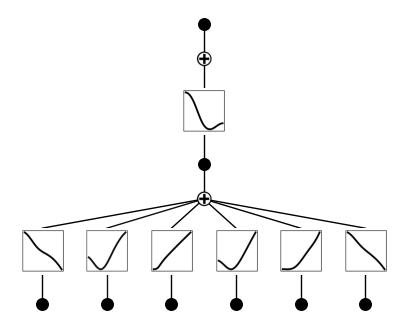

In [2]:
model(dataset['train_input'])
model.plot(beta=10)

In [3]:
# set the (1,0,0) activation to be gausssian
#model.fix_symbolic(1,0,0,lambda x: torch.exp(-x**2/10),fit_params_bool=False)
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)

saving model version 0.1


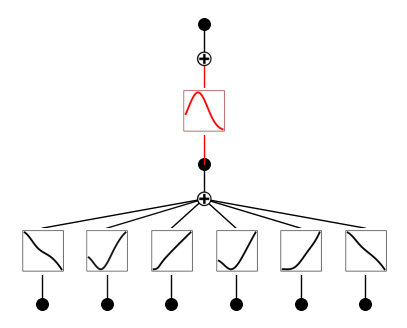

In [4]:
model(dataset['train_input'])
model.plot(beta=10)

In [5]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=10.0, lamb_coef=1.0, grid_update_num=5, stop_grid_update_step=30)

| train_loss: 1.45e-01 | test_loss: 1.70e-01 | reg: 2.43e+01 | : 100%|█| 50/50 [00:04<00:00, 11.07it

saving model version 0.2


{'train_loss': [array(0.46797104),
  array(0.39521653),
  array(0.32942643),
  array(0.2884399),
  array(0.2699764),
  array(0.25123736),
  array(0.23736454),
  array(0.19951615),
  array(0.18453385),
  array(0.16801297),
  array(0.1608766),
  array(0.15125528),
  array(0.14525536),
  array(0.13971204),
  array(0.13833788),
  array(0.13824924),
  array(0.13621678),
  array(0.13534475),
  array(0.1360691),
  array(0.1388433),
  array(0.14289916),
  array(0.14189622),
  array(0.14271643),
  array(0.1425697),
  array(0.14302934),
  array(0.14434401),
  array(0.14615562),
  array(0.14945065),
  array(0.15036858),
  array(0.15031254),
  array(0.15055228),
  array(0.15047704),
  array(0.15067781),
  array(0.1509131),
  array(0.15136792),
  array(0.15180498),
  array(0.15356321),
  array(0.15464328),
  array(0.15628392),
  array(0.15701445),
  array(0.15772918),
  array(0.15792799),
  array(0.1572483),
  array(0.1559823),
  array(0.15498506),
  array(0.15387908),
  array(0.15263123),
  array(

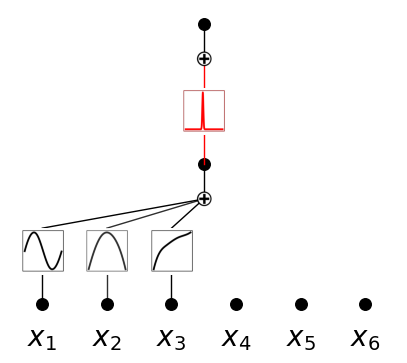

In [6]:
model.plot(in_vars=[r'$x_{}$'.format(i) for i in range(1,7)])

This gives the dependence among $(x_4,x_5)$. Another random seed can give dependence among $(x_1,x_2,x_3)$.

In [7]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9997659964936019, c=2
fixing (0,1,0) with x^2, r2=0.9996460259236992, c=2
fixing (0,2,0) with log, r2=0.9991100134888755, c=2
fixing (0,3,0) with x, r2=0.34104871382246255, c=1
fixing (0,4,0) with x, r2=0.15035438214297514, c=1
fixing (0,5,0) with x, r2=0.30019902811554267, c=1
skipping (1,0,0) since already symbolic
saving model version 0.3


In [8]:
formula_str, inputs = model.symbolic_formula()

In [9]:
ex_round(formula_str[0], 4)

-0.0171 + 1.0323*exp(-552.4994*(-0.4151*x_2**2 + 0.0001*x_5 + 0.4281*log(10.0*x_3 + 0.2) - 0.4174*sin(3.1358*x_1 + 0.0011) - 1)**2)

$\displaystyle - 552.4994 \left(- 0.4151 x_{2}^{2} + 0.0001 x_{5} + 0.4281 \log{\left(10.0 x_{3} + 0.2 \right)} - 0.4174 \sin{\left(3.1358 x_{1} + 0.0011 \right)} - 1\right)^{2}$

In [14]:
scores = model.edge_scores[0]

In [15]:
scores

tensor([[9.4092e-01, 3.8103e-01, 1.0322e+00, 4.1421e-05, 5.0882e-04, 3.4571e-05]],
       grad_fn=<MeanBackward1>)

In [16]:
flat = scores.view(-1)
mean = flat.mean()
std = flat.std()

# Define a dynamic threshold: e.g., mean + 1 std
dynamic_threshold = mean + std
dynamic_threshold *= 0.2
significant_indices = (flat > dynamic_threshold).nonzero(as_tuple=True)[0]
formatted = [f'x{i.item() + 1}' for i in significant_indices]
print("Significantly high value features:", formatted)

Significantly high value features: ['x1', 'x2', 'x3']
